In [2]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Multi-Factor Models

## Implementing the CAPM in Python

### How to do it...

1. Import the libraries:

In [4]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=fca119be7cc0da75637038f89074abe55715bc499f2c9fdac3ed7b8c55b0deab
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [5]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

2. Specify the risky asset and the time horizon:

In this example, we consider the case of Amazon and assume that the S&P 500 index
represents the market. We use 5 years (2014-2018) of monthly data to estimate the beta. In
current times, the risk-free rate is so low that, for simplicity's sake, we assume it is equal to
zero.

In [6]:
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'
START_DATE = '2014-01-01'
END_DATE = '2018-12-31'

3. Download data from Yahoo Finance:

In [7]:
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')
df

Downloaded 1257 rows of data.


Adj Close               ...    Volume            
                   AMZN        ^GSPC  ...      AMZN       ^GSPC
Date                                  ...                      
2014-01-02   397.970001  1831.979980  ...   2137800  3080600000
2014-01-03   396.440002  1831.369995  ...   2210200  2774270000
2014-01-06   393.630005  1826.770020  ...   3170600  3294850000
2014-01-07   398.029999  1837.880005  ...   1916000  3511750000
2014-01-08   401.920013  1837.489990  ...   2316500  3652140000
...                 ...          ...  ...       ...         ...
2018-12-21  1377.449951  2416.620117  ...  13640300  7609010000
2018-12-24  1343.959961  2351.100098  ...   7220000  2613930000
2018-12-26  1470.900024  2467.699951  ...  10411800  4233990000
2018-12-27  1461.640015  2488.830078  ...   9722000  4096610000
2018-12-28  1478.020020  2485.739990  ...   8829000  3702620000

[1257 rows x 12 columns]

4. Resample to monthly data and calculate simple returns:

In [18]:
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset',MARKET_BENCHMARK: 'market'})\
                   .resample('M') \
                   .last() \
                   .pct_change() \
                   .dropna()
X.head()
# asset: AMZN, market: GSPC

,asset,market
Date,,
2014-02-28,0.009507,0.043117
2014-03-31,-0.071058,0.006932
2014-04-30,-0.095847,0.006201
2014-05-31,0.027685,0.021030
2014-06-30,0.039130,0.019058


5. Calculate beta using the covariance approach: 

In [19]:
 X.cov()

,asset,market
asset,0.007302,0.001636
market,0.001636,0.001004


In [20]:
X.cov().iloc[0,1] # hệ số tương quan giữa market và asset - covariance

0.0016357133709914617

In [21]:
X.market.var() # variance của market - benchmark_variance

0.0010037463204542111

In [22]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

1.6296083359501388

6. Prepare the input and estimate CAPM as a linear regression:

In [23]:
# separate target
y = X.pop('asset')

In [24]:
X.head()

,market
Date,
2014-02-28,0.043117
2014-03-31,0.006932
2014-04-30,0.006201
2014-05-31,0.021030
2014-06-30,0.019058


In [25]:
# add constant
X = sm.add_constant(X)
X.head()

,const,market
Date,,
2014-02-28,1.0,0.043117
2014-03-31,1.0,0.006932
2014-04-30,1.0,0.006201
2014-05-31,1.0,0.021030
2014-06-30,1.0,0.019058


In Step 6, we separated the target (Amazon's stock returns) and the features (S&P 500
returns) using the pop method of a pandas DataFrame. Afterward, we added the constant
to the features (effectively adding a column of ones) with the add_constant function. The
idea behind adding the intercept to this regression is to investigate whether—after
estimating the model—the intercept (in the case of the CAPM, also known as Jensen's
alpha) is zero. If it is positive and significant, it means that– assuming the CAPM model is
true—the asset or portfolio generates abnormally high risk-adjusted returns. There are two
possible implications—either the market is inefficient or there are some other undiscovered
risk factors that should be included in the model. This issue is known as the joint
hypothesis problem.

In [26]:
# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     32.77
Date:                Fri, 24 Jul 2020   Prob (F-statistic):           4.05e-07
Time:                        11:58:05   Log-Likelihood:                 75.313
No. Observations:                  59   AIC:                            -146.6
Df Residuals:                      57   BIC:                            -142.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0178      0.009      1.950      0.0

AMZN = 1.639 market + 0.0178. Nghia la AMZN gap 1.639 market, hon 64%

These results indicate that the beta (denoted as market here) is equal to 1.67,
which means that Amazon's returns are 67% more volatile than the market
(proxied by S&P 500). The value of the intercept is relatively small and
statistically insignificant at the 5% significance level.

Lastly, we ran the OLS regression and printed the summary. Here, we could see that the
coefficient by the market variable (that is, the CAPM beta) is equal to the beta that was
calculated using the covariance between the asset and the market in Step 5.

### There's more...

#### Risk-free rate (13 Week Treasury Bill)

The second option is to approximate the risk-free rate with, for example, the 13
Week (3-month) Treasury Bill (Yahoo finance ticker: ^IRX).

In [28]:
# period lenght in days
N_DAYS = 90

# download data from Yahoo finance
df_rf = yf.download('^IRX',
                    start=START_DATE,
                    end=END_DATE,
                    progress=False)
df_rf

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,0.060,0.060,0.055,0.058,0.058,0
2014-01-03,0.060,0.060,0.058,0.058,0.058,0
2014-01-06,0.055,0.055,0.045,0.045,0.045,0
2014-01-07,0.048,0.048,0.040,0.043,0.043,0
2014-01-08,0.037,0.043,0.035,0.040,0.040,0
...,...,...,...,...,...,...
2018-12-20,2.340,2.345,2.335,2.335,2.335,0
2018-12-21,2.320,2.338,2.318,2.330,2.330,0
2018-12-26,2.385,2.390,2.373,2.380,2.380,0


In [30]:
# resample to monthly by taking last value from each month
rf = df_rf.resample('M').last().Close / 100
rf

Date
2014-01-31    0.00010
2014-02-28    0.00043
2014-03-31    0.00028
2014-04-30    0.00020
2014-05-31    0.00030
2014-06-30    0.00020
2014-07-31    0.00018
2014-08-31    0.00018
2014-09-30    0.00013
2014-10-31    0.00003
2014-11-30    0.00010
2014-12-31    0.00037
2015-01-31    0.00005
2015-02-28    0.00008
2015-03-31    0.00025
2015-04-30    0.00005
2015-05-31    0.00003
2015-06-30    0.00010
2015-07-31    0.00058
2015-08-31    0.00003
2015-09-30    0.00005
2015-10-31    0.00068
2015-11-30    0.00170
2015-12-31    0.00148
2016-01-31    0.00300
2016-02-29    0.00308
2016-03-31    0.00193
2016-04-30    0.00193
2016-05-31    0.00283
2016-06-30    0.00248
2016-07-31    0.00240
2016-08-31    0.00320
2016-09-30    0.00260
2016-10-31    0.00295
2016-11-30    0.00468
2016-12-31    0.00480
2017-01-31    0.00500
2017-02-28    0.00523
2017-03-31    0.00738
2017-04-30    0.00780
2017-05-31    0.00950
2017-06-30    0.00993
2017-07-31    0.01053
2017-08-31    0.00978
2017-09-30    0.01028
2017-

In [31]:

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * N_DAYS / 360) )**(1 / N_DAYS)  
rf

Date
2014-01-31    1.000000
2014-02-28    1.000001
2014-03-31    1.000001
2014-04-30    1.000001
2014-05-31    1.000001
2014-06-30    1.000001
2014-07-31    1.000001
2014-08-31    1.000001
2014-09-30    1.000000
2014-10-31    1.000000
2014-11-30    1.000000
2014-12-31    1.000001
2015-01-31    1.000000
2015-02-28    1.000000
2015-03-31    1.000001
2015-04-30    1.000000
2015-05-31    1.000000
2015-06-30    1.000000
2015-07-31    1.000002
2015-08-31    1.000000
2015-09-30    1.000000
2015-10-31    1.000002
2015-11-30    1.000005
2015-12-31    1.000004
2016-01-31    1.000008
2016-02-29    1.000009
2016-03-31    1.000005
2016-04-30    1.000005
2016-05-31    1.000008
2016-06-30    1.000007
2016-07-31    1.000007
2016-08-31    1.000009
2016-09-30    1.000007
2016-10-31    1.000008
2016-11-30    1.000013
2016-12-31    1.000013
2017-01-31    1.000014
2017-02-28    1.000015
2017-03-31    1.000021
2017-04-30    1.000022
2017-05-31    1.000026
2017-06-30    1.000028
2017-07-31    1.000029
2017-0

In [32]:


# convert to monthly and subtract 1
rf = (rf ** 30) - 1 
rf

Date
2014-01-31    0.000008
2014-02-28    0.000036
2014-03-31    0.000023
2014-04-30    0.000017
2014-05-31    0.000025
2014-06-30    0.000017
2014-07-31    0.000015
2014-08-31    0.000015
2014-09-30    0.000011
2014-10-31    0.000003
2014-11-30    0.000008
2014-12-31    0.000031
2015-01-31    0.000004
2015-02-28    0.000007
2015-03-31    0.000021
2015-04-30    0.000004
2015-05-31    0.000003
2015-06-30    0.000008
2015-07-31    0.000048
2015-08-31    0.000003
2015-09-30    0.000004
2015-10-31    0.000057
2015-11-30    0.000142
2015-12-31    0.000123
2016-01-31    0.000250
2016-02-29    0.000257
2016-03-31    0.000161
2016-04-30    0.000161
2016-05-31    0.000236
2016-06-30    0.000207
2016-07-31    0.000200
2016-08-31    0.000267
2016-09-30    0.000217
2016-10-31    0.000246
2016-11-30    0.000390
2016-12-31    0.000400
2017-01-31    0.000417
2017-02-28    0.000436
2017-03-31    0.000616
2017-04-30    0.000651
2017-05-31    0.000793
2017-06-30    0.000829
2017-07-31    0.000879
2017-0

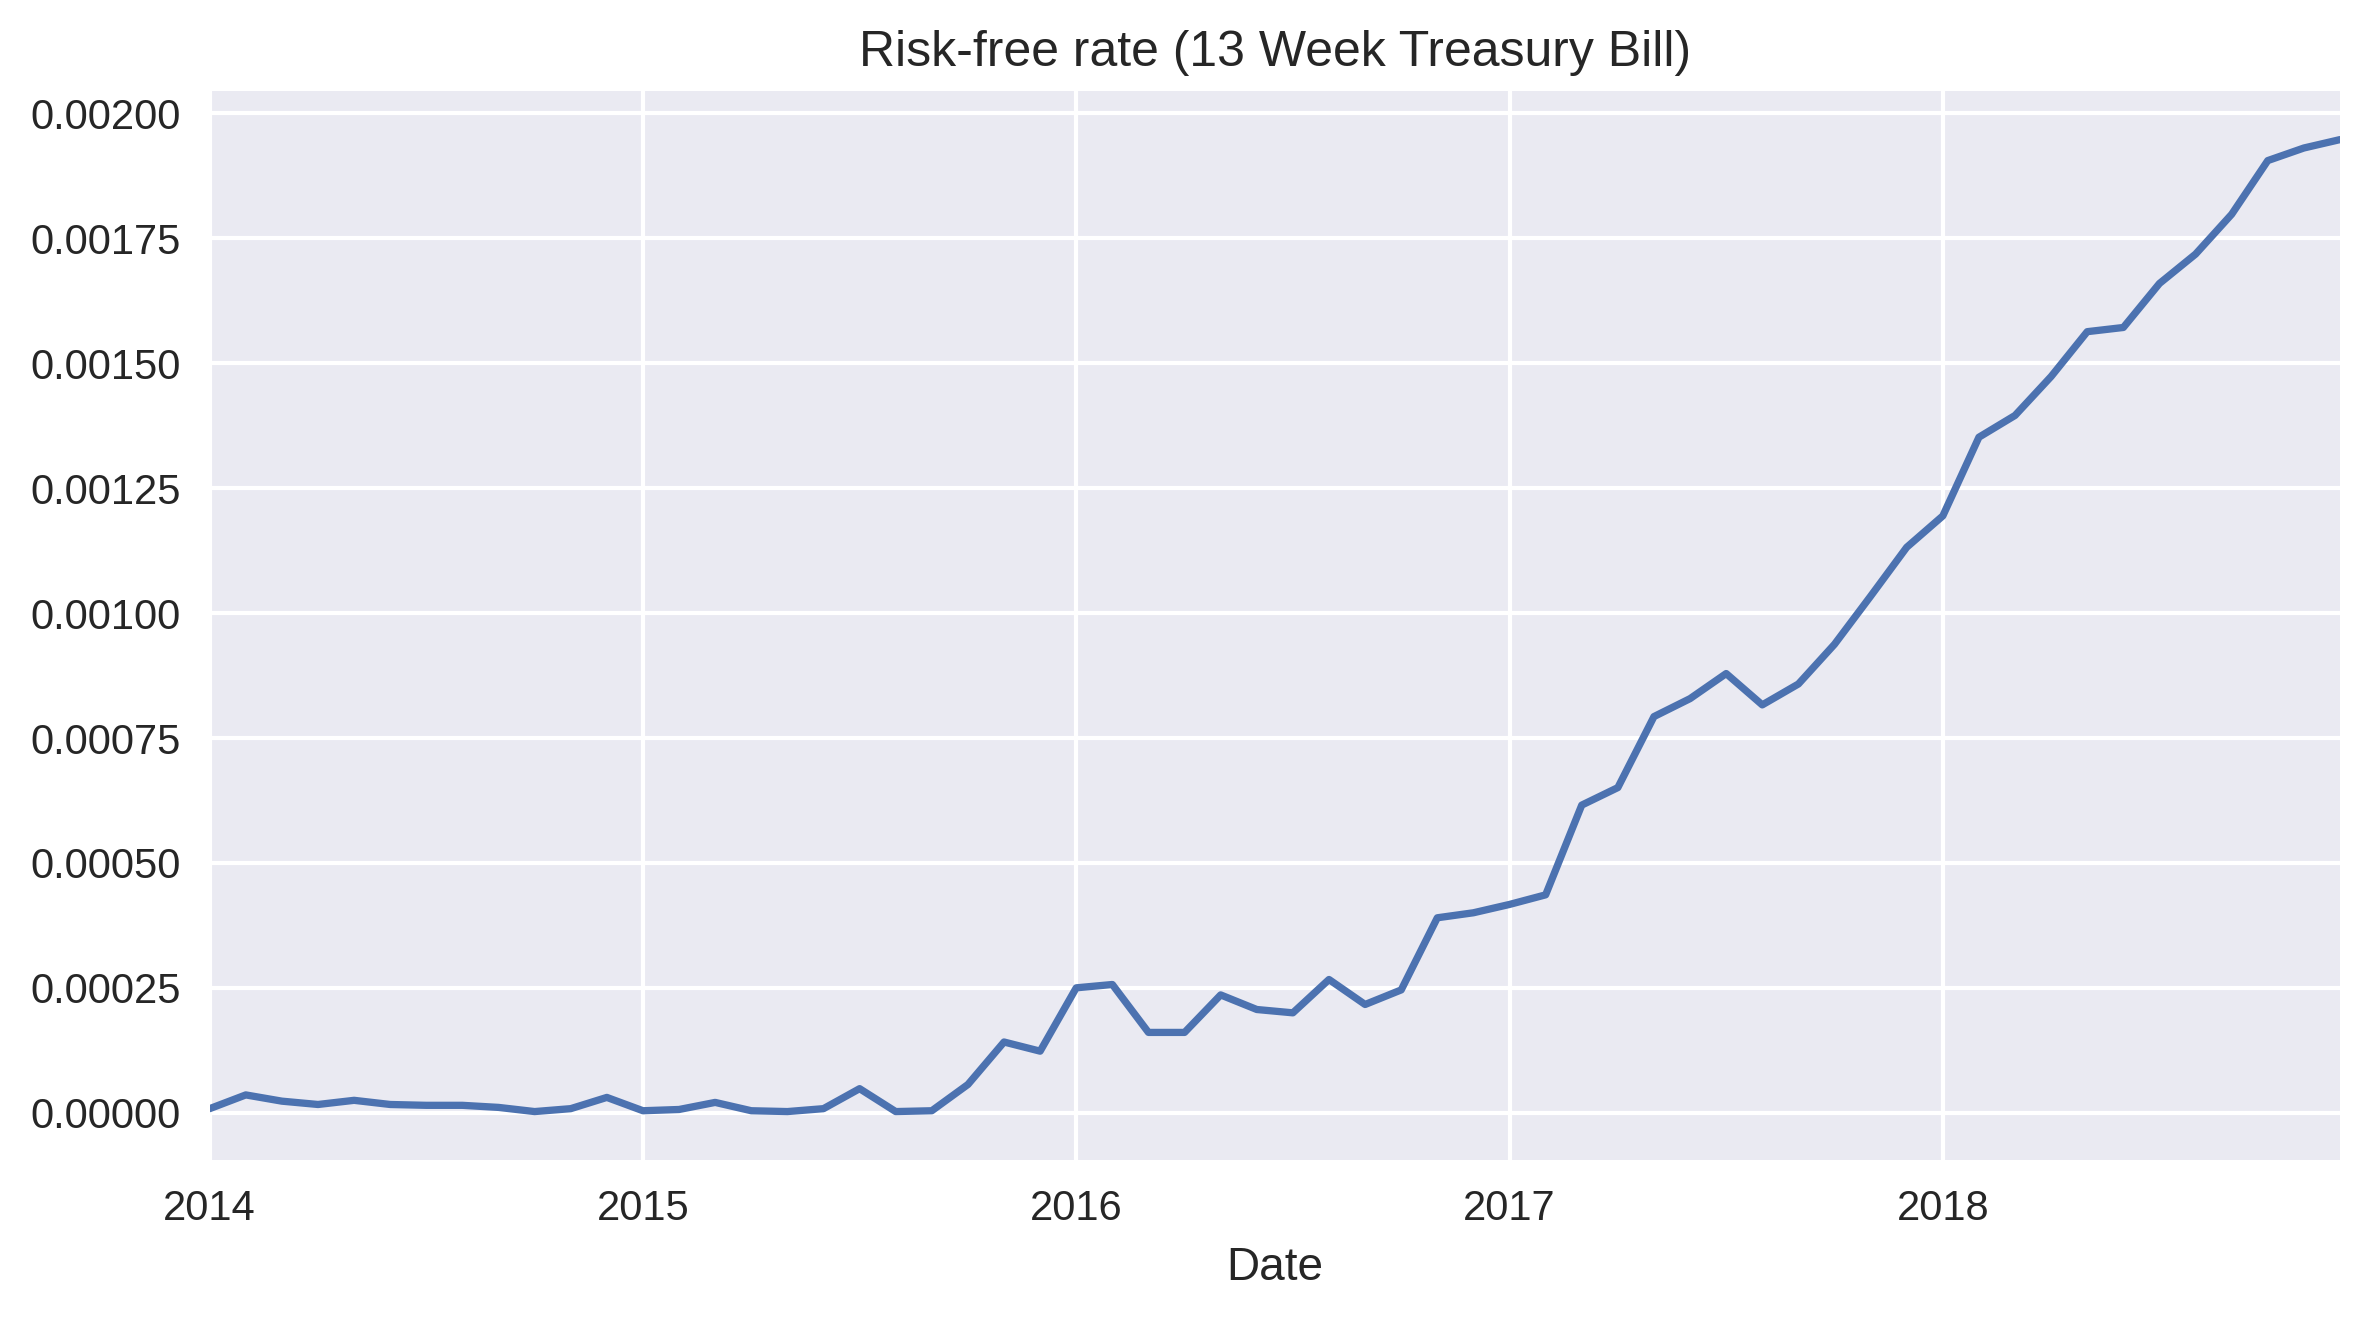

In [33]:
# plot the risk-free rate
rf.plot(title='Risk-free rate (13 Week Treasury Bill)')

plt.tight_layout()
# plt.savefig('images/ch4_im2.png')
plt.show()

#### Risk-free rate (3-Month Treasury Bill)

In [34]:
import pandas_datareader.data as web

# download the data 
rf = web.DataReader('TB3MS', 'fred', start=START_DATE, end=END_DATE)
rf

,TB3MS
DATE,
2014-01-01,0.04
2014-02-01,0.05
2014-03-01,0.05
2014-04-01,0.03
2014-05-01,0.03
2014-06-01,0.04
2014-07-01,0.03
2014-08-01,0.03
2014-09-01,0.02


In [35]:
# convert to monthly
rf = (1 + (rf / 100)) ** (1 / 12) - 1
rf

,TB3MS
DATE,
2014-01-01,0.000033
2014-02-01,0.000042
2014-03-01,0.000042
2014-04-01,0.000025
2014-05-01,0.000025
2014-06-01,0.000033
2014-07-01,0.000025
2014-08-01,0.000025
2014-09-01,0.000017


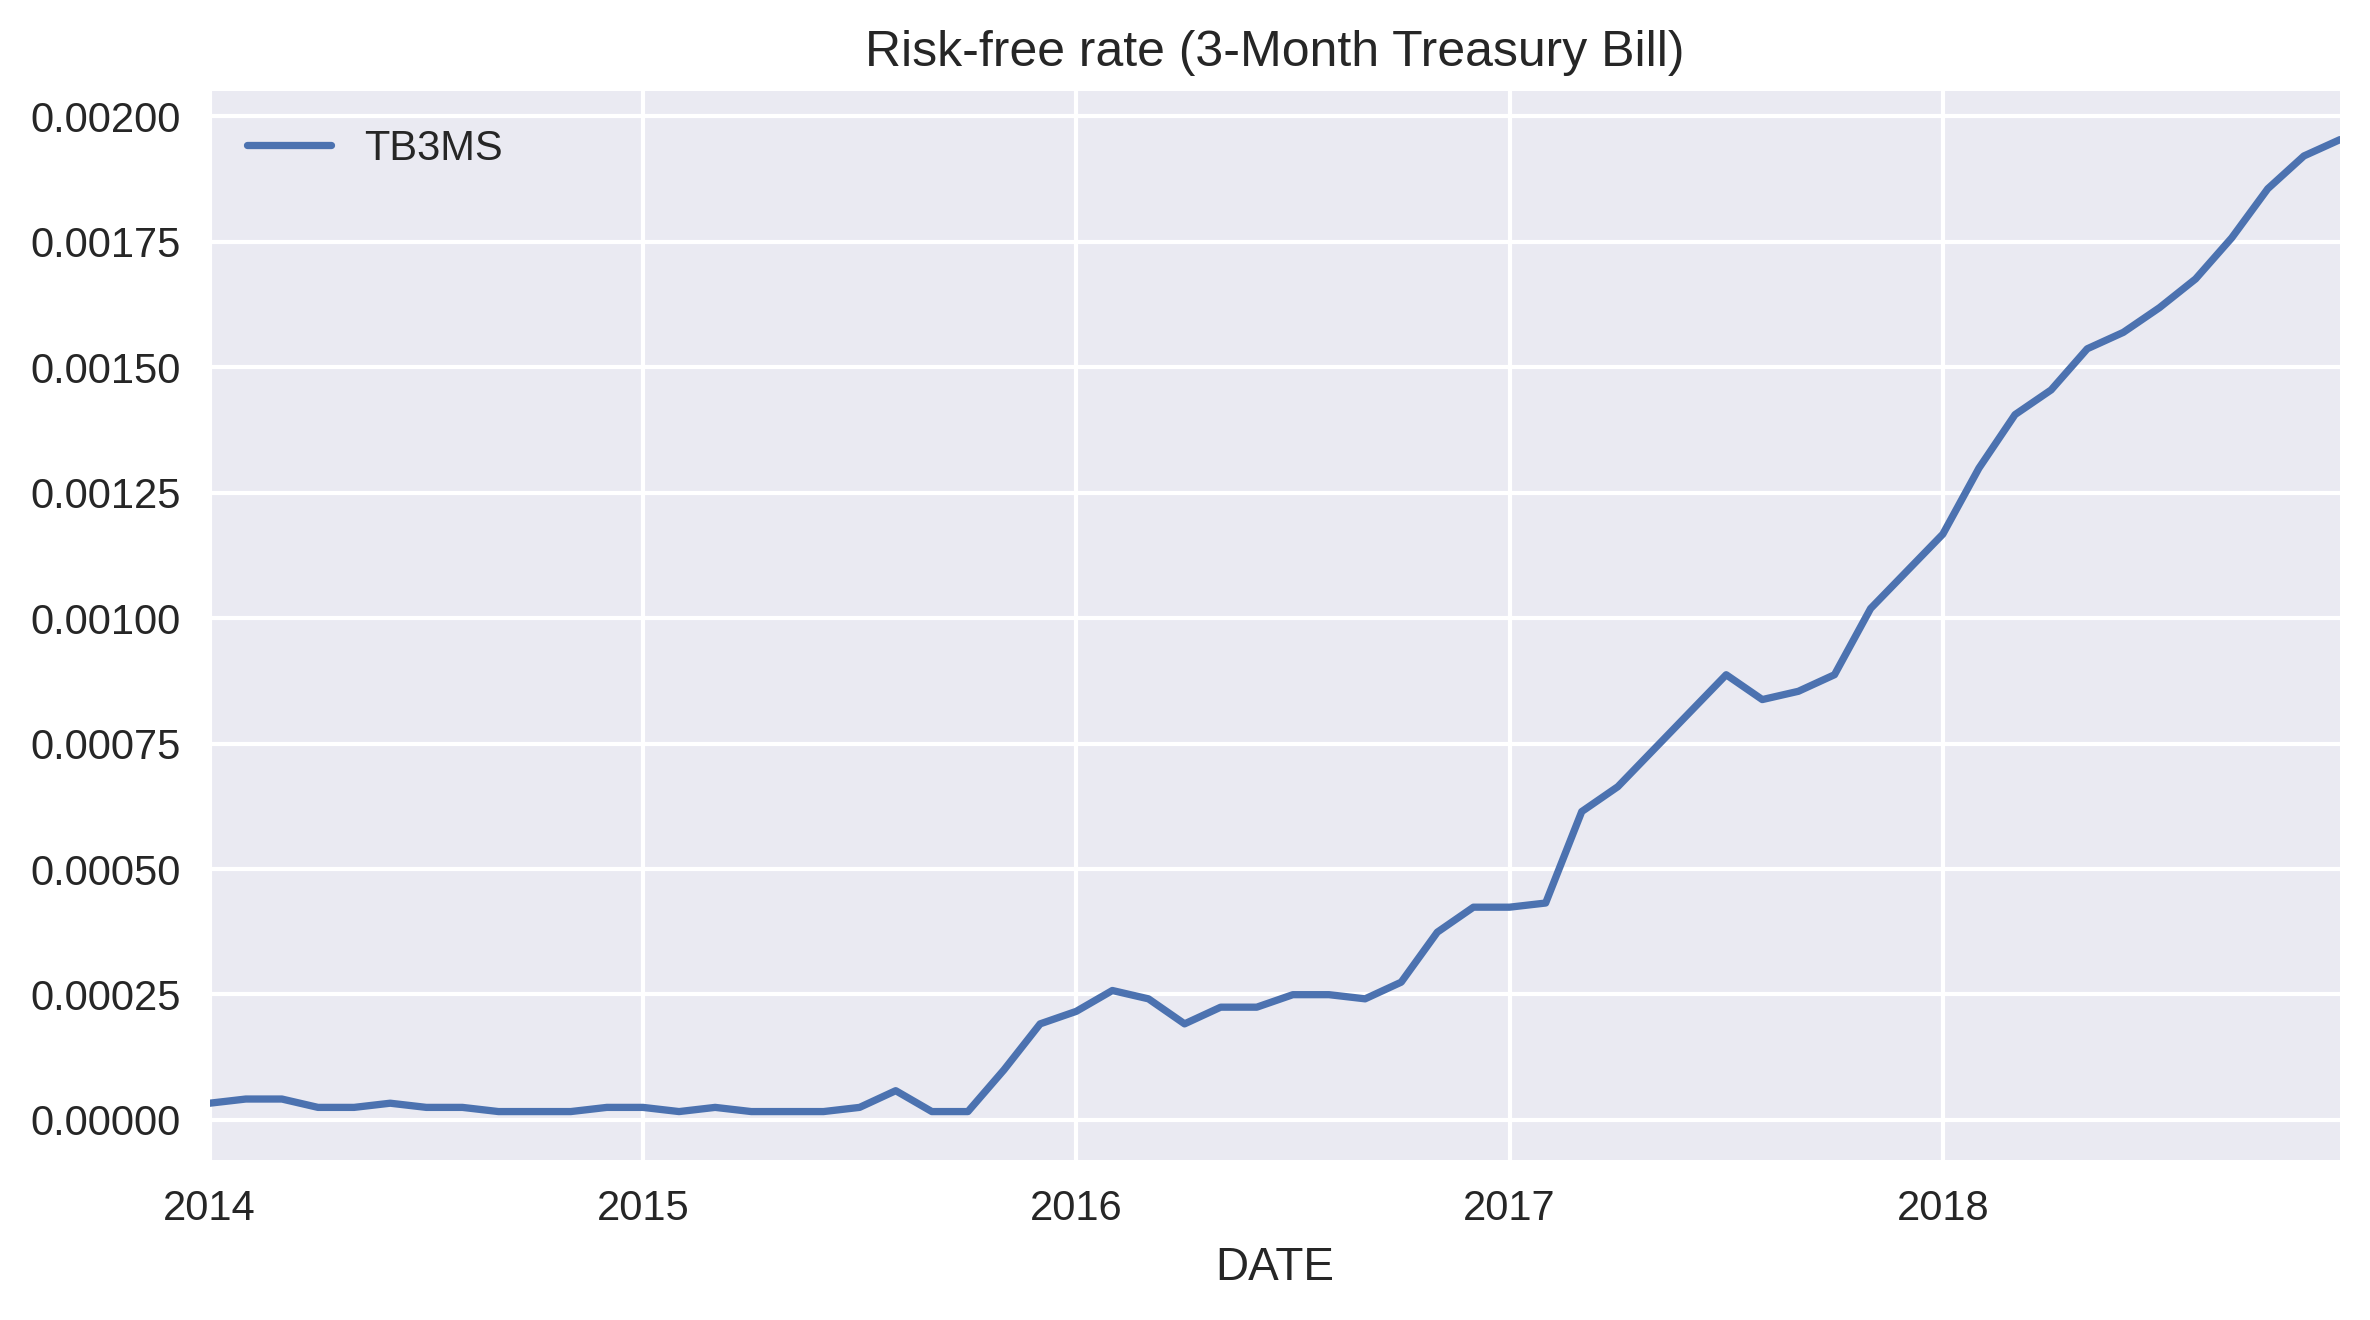

In [36]:
# plot the risk-free rate
rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

plt.tight_layout()
# plt.savefig('images/ch4_im3.png')
plt.show()

## Implementing the Fama-French three-factor model in Python

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf

2. Download data from prof. French's website:

In [ ]:
# download the zip file from Prof. French's website
!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip

# unpack the zip
!unzip -a F-F_Research_Data_Factors_CSV.zip

# remove the zip
!rm F-F_Research_Data_Factors_CSV.zip

--2020-01-19 20:59:24--  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.181.201
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.181.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12339 (12K) [application/x-zip-compressed]
Saving to: 'F-F_Research_Data_Factors_CSV.zip'

F-F_Research_Data_F 100%[===================>]  12.05K  --.-KB/s    in 0.02s   

2020-01-19 20:59:26 (495 KB/s) - 'F-F_Research_Data_Factors_CSV.zip' saved [12339/12339]

Archive:  F-F_Research_Data_Factors_CSV.zip
  inflating: F-F_Research_Data_Factors.CSV  [binary]


3. Define parameters:

In [ ]:
RISKY_ASSET = 'FB'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

4. Load data from the source CSV file and keep only the monthly data:

In [ ]:
# load data from csv
factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)

# identify where the annual data starts
STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]

# keep only monthly data
factor_df = factor_df[factor_df.index < start_of_annual]

5. Rename columns of the DataFrame, set a datetime index and filter by dates:

In [ ]:
# rename columns
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']

# convert strings to datetime
factor_df['date'] = pd.to_datetime(factor_df['date'], 
                                   format='%Y%m') \
                      .dt.strftime("%Y-%m")

# set index
factor_df = factor_df.set_index('date')

# filter only required dates
factor_df = factor_df.loc[START_DATE:END_DATE]

6. Convert the values to numeric and divide by 100:

In [ ]:
factor_df = factor_df.apply(pd.to_numeric, 
                            errors='coerce') \
                     .div(100)
factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-0.0332,0.0085,-0.0209,0.0
2014-02,0.0465,0.0034,-0.0040,0.0
2014-03,0.0043,-0.0189,0.0509,0.0
2014-04,-0.0019,-0.0424,0.0114,0.0
2014-05,0.0206,-0.0186,-0.0027,0.0


7. Download the prices of the risky asset:

In [ ]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1259 rows of data.


8. Calculate monthly returns on the risky asset:

In [ ]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'
y.head()

2014-01    0.144922
2014-02    0.094135
2014-03   -0.120070
2014-04   -0.007636
2014-05    0.058883
Name: rtn, dtype: float64

9. Merge the datasets and calculate excess returns:

In [ ]:
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

10. Estimate the three-factor model:

In [ ]:
# define and fit the regression model 
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', 
                   data=ff_data).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     5.175
Date:                Sat, 25 Jan 2020   Prob (F-statistic):            0.00316
Time:                        21:50:09   Log-Likelihood:                 88.392
No. Observations:                  60   AIC:                            -168.8
Df Residuals:                      56   BIC:                            -160.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0105      0.008      1.373      0.1

### There's more...

1. Import the libraries:

In [ ]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

2. Print available datasets (here only first 5):

In [ ]:
get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

3. Download the selected dataset:

In [ ]:
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                         start='2014-01-01')

In [ ]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

4. Inspect the description of the dataset

In [ ]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 201912 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2019 Kenneth R. French

  0 : (72 rows x 4 cols)
  1 : Annual Factors: January-December (6 rows x 4 cols)


5. View the monthly dataset:

In [ ]:
ff_dict[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-01,-3.32,0.85,-2.09,0.0
2014-02,4.65,0.34,-0.40,0.0
2014-03,0.43,-1.89,5.09,0.0
2014-04,-0.19,-4.24,1.14,0.0
2014-05,2.06,-1.86,-0.27,0.0


## Implementing the rolling three-factor model on a portfolio of assets

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Define the parameters:

In [ ]:
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2009-12-31'
END_DATE = '2018-12-31'

3. Download the factor related data:

In [ ]:
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

4. Download the prices of risky assets from Yahoo Finance:

In [ ]:
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 2265 rows of data.


5. Calculate the monthly returns on the risky assets:

In [ ]:
asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()
# reformat index for joining
asset_df.index = asset_df.index.strftime('%Y-%m')

6. Calculate the portfolio returns:

In [ ]:
asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, 
                                          WEIGHTS)
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
2010-01,-0.088583,-0.067722,-0.145226,-0.075448,-0.094245
2010-02,0.065354,-0.055897,-0.005910,0.022092,0.006410
2010-03,0.148643,0.146706,0.076519,0.021614,0.098371
2010-04,0.110921,0.009796,-0.073027,0.042746,0.022609
2010-05,-0.016025,-0.084902,-0.076221,-0.151553,-0.082175


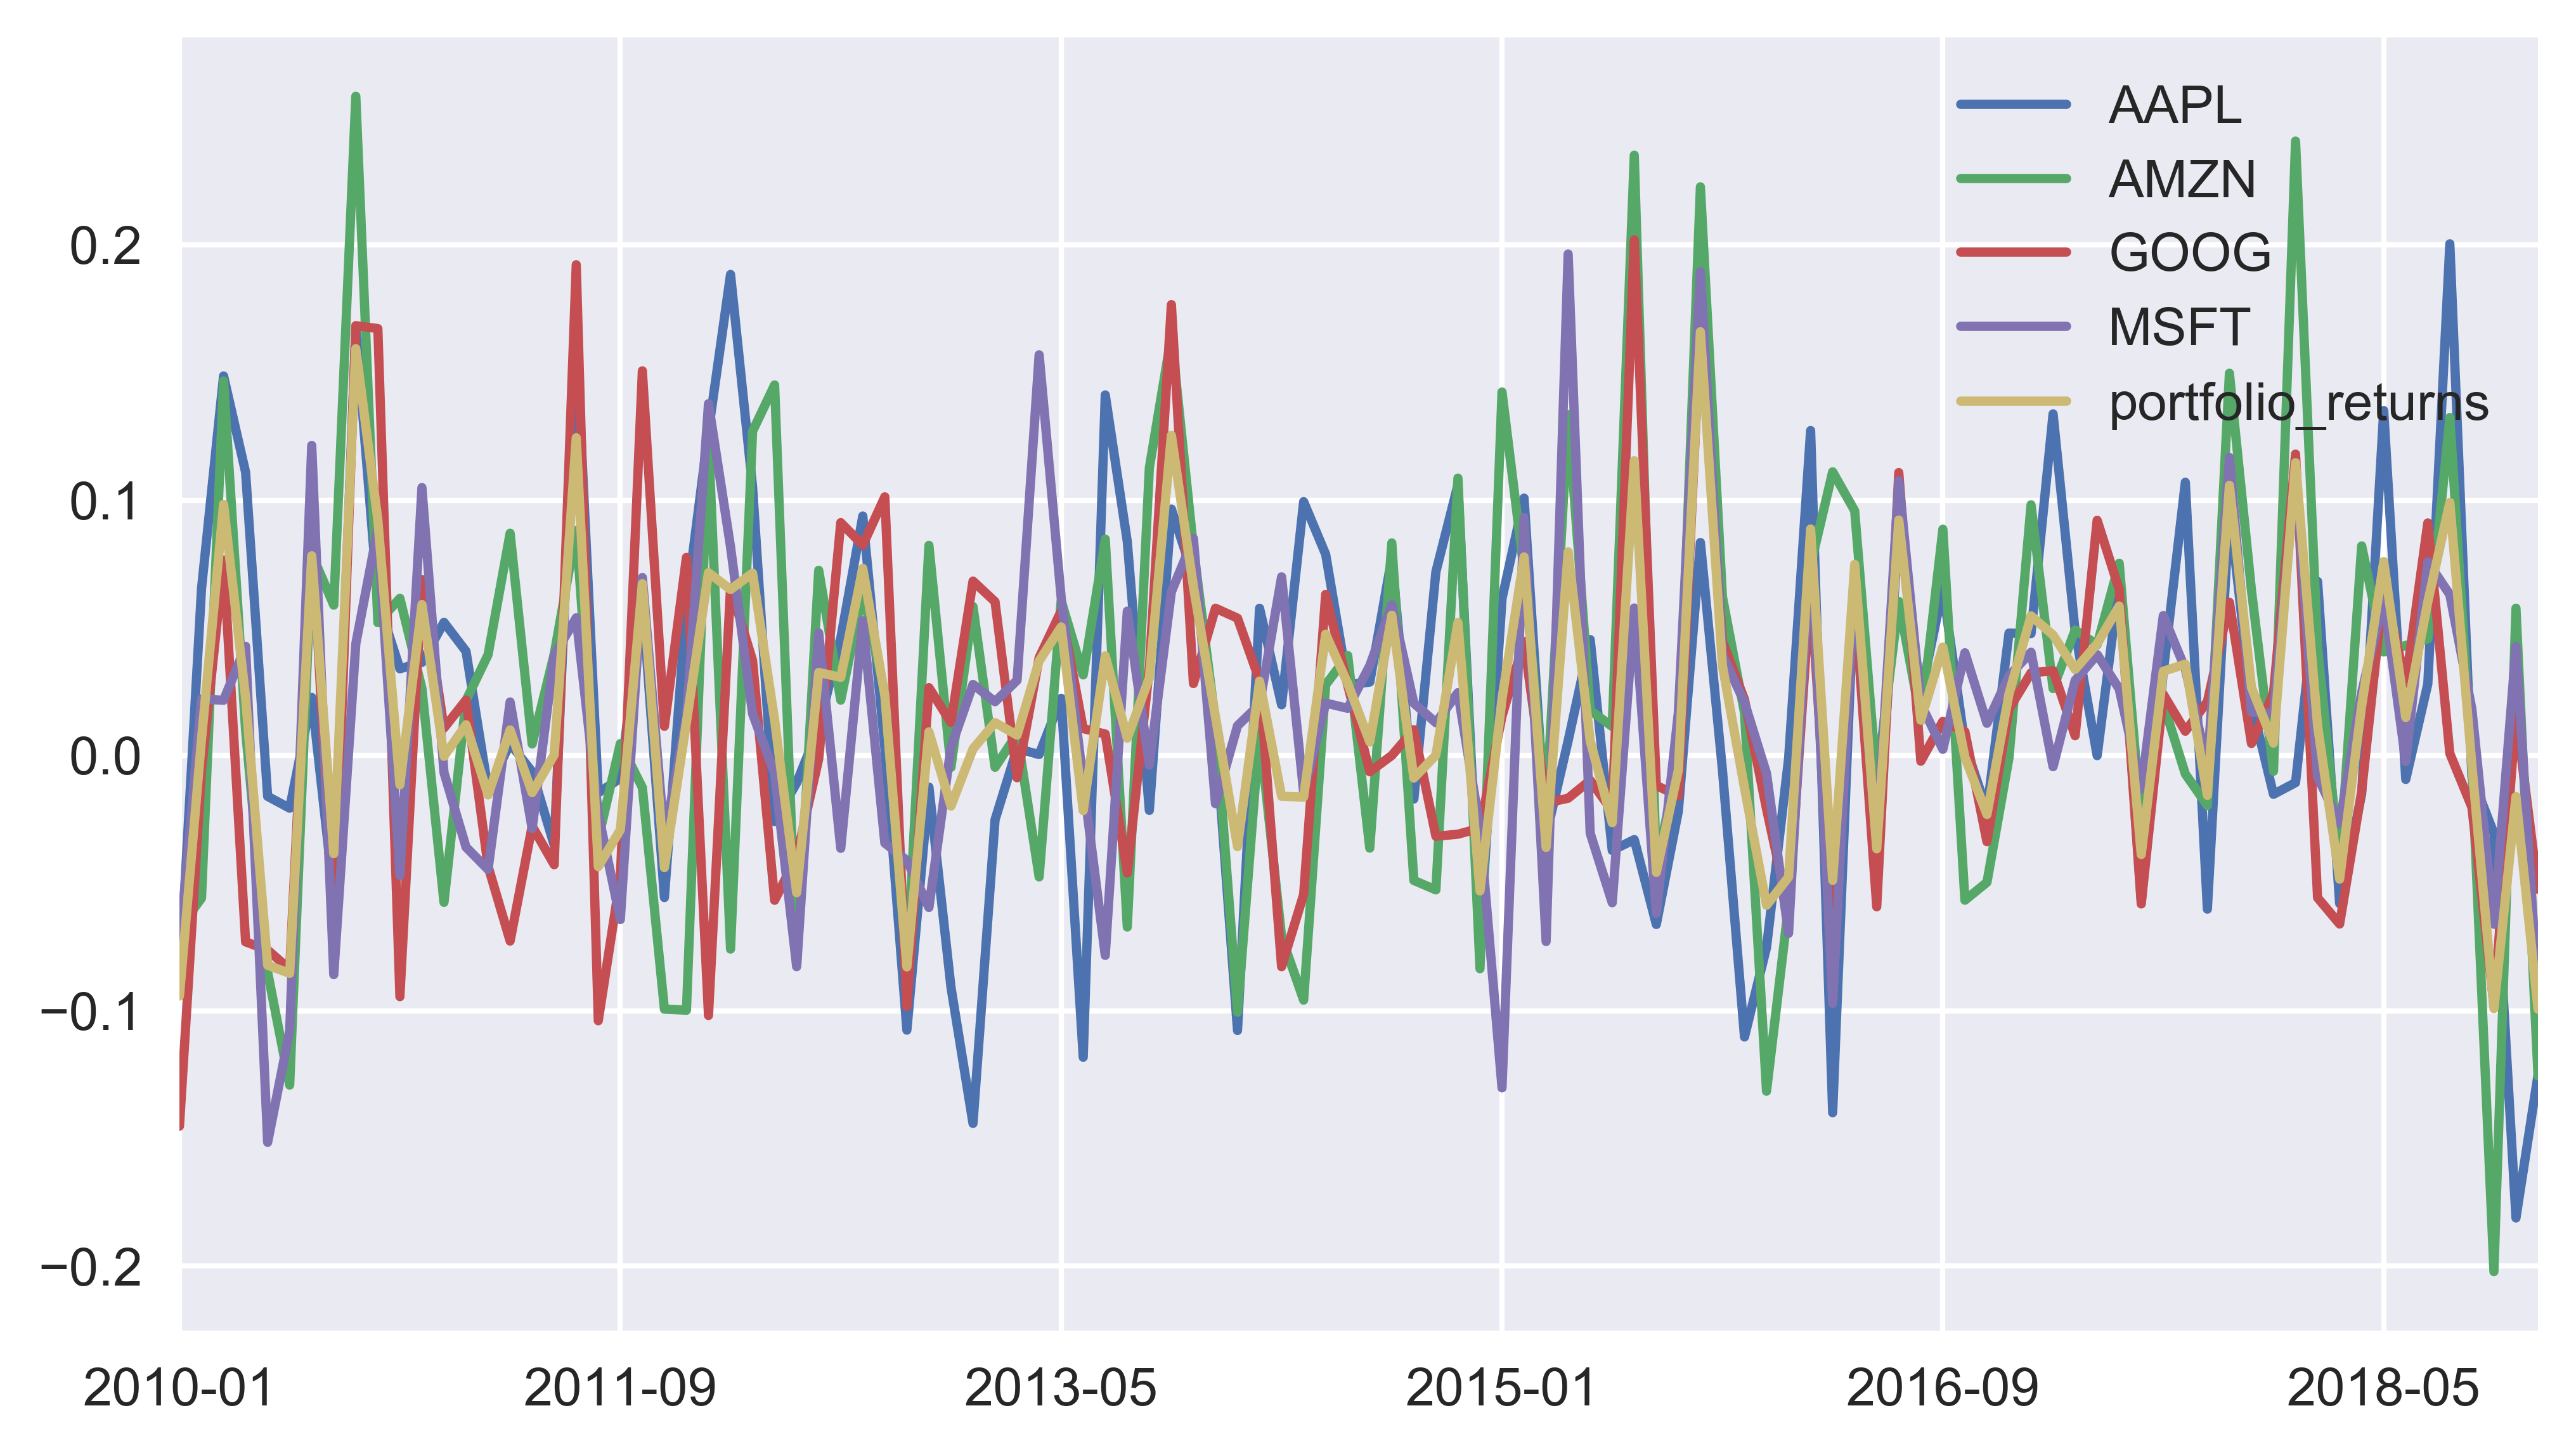

In [ ]:
asset_df.plot()

7. Merge the datasets:

In [ ]:
ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

In [ ]:
ff_data.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
2010-01,-0.094245,-0.0336,0.0038,0.0030,0.0000,-0.094245
2010-02,0.006410,0.0340,0.0121,0.0316,0.0000,0.006410
2010-03,0.098371,0.0631,0.0143,0.0211,0.0001,0.098271
2010-04,0.022609,0.0200,0.0497,0.0281,0.0001,0.022509
2010-05,-0.082175,-0.0789,0.0005,-0.0238,0.0001,-0.082275


8. Define a function for the rolling n-factor model

In [ ]:
def rolling_factor_model(input_data, formula, window_size):
    '''
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    '''

    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):        
        end_index = start_index + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_index:end_index]
        ).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

9. Estimate the rolling three-factor model and plot the results:

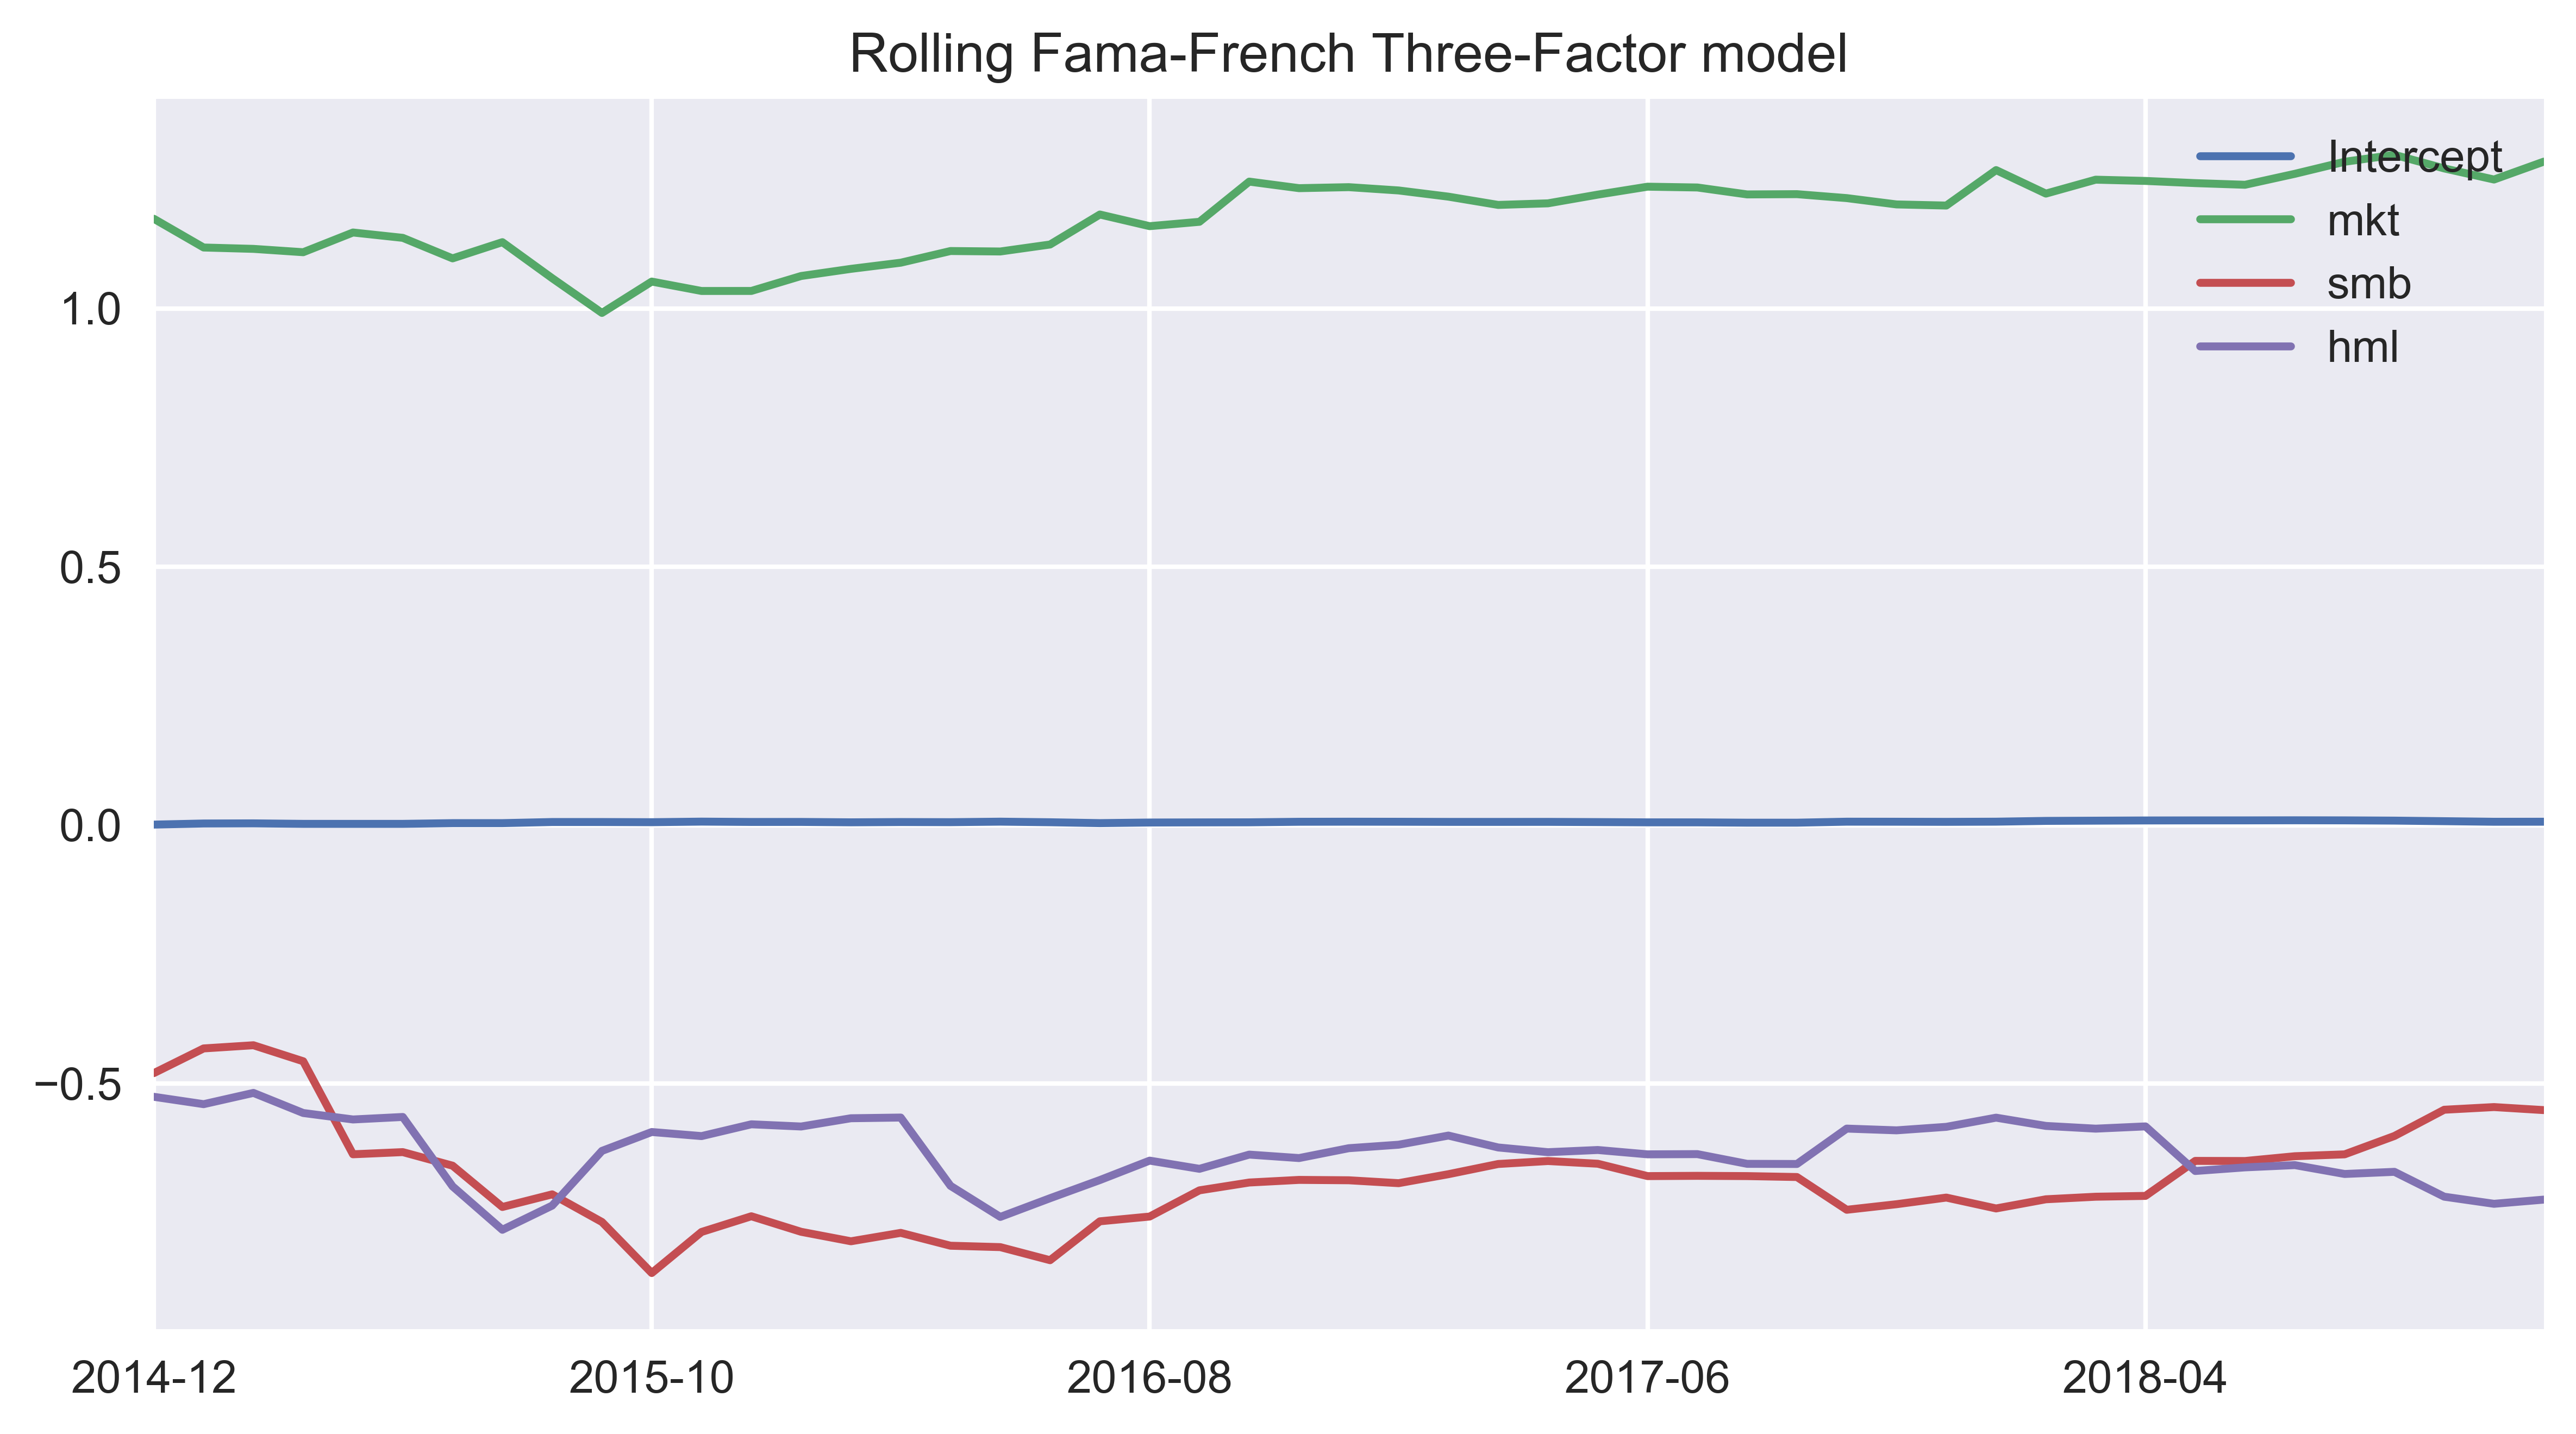

In [ ]:
MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, 
                                  MODEL_FORMULA, 
                                  window_size=60)
results_df.plot(title = 'Rolling Fama-French Three-Factor model')

plt.tight_layout()
# plt.savefig('images/ch4_im8.png')
plt.show()

## Implementing the four- and five-factor models in Python

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

2. Specify the risky asset and the time horizon:

In [ ]:
RISKY_ASSET = 'AMZN'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

3. Download the risk factors from prof. French's website:

In [ ]:
# three factors 
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor.index = df_three_factor.index.format()

# momentum factor
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', 
                        start=START_DATE)[0]
df_mom.index = df_mom.index.format()

# five factors
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                                'famafrench', 
                                start=START_DATE)[0]
df_five_factor.index = df_five_factor.index.format()

4. Download the data of the risky asset from Yahoo Finance:

In [ ]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1259 rows of data.


5. Calculate monthly returns:

In [ ]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'return'

6. Merge the datasets for the four-factor models:

In [ ]:
# join all datasets on the index
four_factor_data = df_three_factor.join(df_mom).join(y)

# rename columns
four_factor_data.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']

# divide everything (except returns) by 100
four_factor_data.loc[:, four_factor_data.columns != 'rtn'] /= 100

# convert index to datetime
four_factor_data.index = pd.to_datetime(four_factor_data.index, 
                                        format='%Y-%m')

# select period of interest
four_factor_data = four_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
four_factor_data['excess_rtn'] = four_factor_data.rtn - four_factor_data.rf

four_factor_data.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2014-01-01,-0.0332,0.0085,-0.0209,0.0,0.0170,-0.100554,-0.100554
2014-02-01,0.0465,0.0034,-0.0040,0.0,0.0207,0.009507,0.009507
2014-03-01,0.0043,-0.0189,0.0509,0.0,-0.0334,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0424,0.0114,0.0,-0.0386,-0.095847,-0.095847
2014-05-01,0.0206,-0.0186,-0.0027,0.0,0.0115,0.027686,0.027686


7. Merge the datasets for the five-factor models:

In [ ]:
# join all datasets on the index
five_factor_data = df_five_factor.join(y)

# rename columns
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']

# divide everything (except returns) by 100
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

# convert index to datetime
five_factor_data.index = pd.to_datetime(five_factor_data.index, 
                                        format='%Y-%m')

# select period of interest
five_factor_data = five_factor_data.loc[START_DATE:END_DATE]

# calculate excess returns
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

five_factor_data.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2014-01-01,-0.0332,0.0057,-0.0209,-0.0399,-0.0140,0.0,-0.100554,-0.100554
2014-02-01,0.0465,0.0015,-0.0040,-0.0026,-0.0041,0.0,0.009507,0.009507
2014-03-01,0.0043,-0.0117,0.0509,0.0216,0.0190,0.0,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0415,0.0114,0.0348,0.0107,0.0,-0.095847,-0.095847
2014-05-01,0.0206,-0.0189,-0.0027,0.0010,-0.0108,0.0,0.027686,0.027686


8. Estimate the four-factor model:

In [ ]:
four_factor_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml + mom', 
                            data=four_factor_data).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     16.77
Date:                Sun, 19 Jan 2020   Prob (F-statistic):           4.82e-09
Time:                        21:31:16   Log-Likelihood:                 86.244
No. Observations:                  60   AIC:                            -162.5
Df Residuals:                      55   BIC:                            -152.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0094      0.008      1.164      0.2

9. Estimate the five-factor model:

In [ ]:
five_factor_model = smf.ols(
    formula='excess_rtn ~ mkt + smb + hml + rmw + cma', 
    data=five_factor_data
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     15.85
Date:                Sun, 19 Jan 2020   Prob (F-statistic):           1.38e-09
Time:                        21:31:18   Log-Likelihood:                 89.416
No. Observations:                  60   AIC:                            -166.8
Df Residuals:                      54   BIC:                            -154.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0101      0.008      1.308      0.1